In [ ]:
!pip install alpha_vantage -q
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
from torch.optim import Adam, lr_scheduler
from torchvision.transforms import ToTensor
from torchinfo import summary


import os
import numpy as np
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
import pandas as pd

### Data

In [ ]:
color = {
    "actual": "#323031",
    "train": "#FFC857",
    "val": "#ED8146",
    "pred_train": "#DB3A34",
    "pred_val": "#084C61",
    "pred_test": "#177E89"
    }

In [ ]:
api_key = "Q5XTRJM8KH39F6WF"
company_symbol = 'GOOGL'
company_name = 'Google'

In [ ]:
seq_length = 20
split_ratio = 0.8

In [ ]:
def download_data(company_symbol):
  column_names = ['open', 'high', 'low', 'close', 'adjusted_close', 'volume', 'dividend']
  ts = TimeSeries(key=api_key)
  data, meta_data = ts.get_weekly_adjusted(company_symbol)
  # Convert dictionary to dataframe
  df = pd.DataFrame(data)
  df = df.transpose()
  # Change the name of headers and index
  df.columns = column_names
  df.index.name = 'date'
  # Reverse from past to present
  df = df[::-1]
  # Convert all to numeric
  for col in column_names:
    df[col] = pd.to_numeric(df[col])
  return df

In [ ]:
def plot_data(data_raw=None, data_split=None, mode='raw'):
  """Plot data of mode raw, split (train/val), and compare

  Args:
    data: ndarray of original data
    data_split: dictionary of
      {
       'train': train data/predicted train data,
       'val': val data / predicted val data,
       'split_index': the index indicates number of train and val data,
       'scaler': normalize object of corresponding data
      }
      based on the mode 'split/compare'
    mode:
      raw - plot original data,
      split - plot train and val data,
      compare - plot original data compare to predicted train and val data
  """
  date = data.index
  num_data_points = len(date)
  xticks_interval = num_data_points * 90 // 5417
  display_date_range = f"from {date[0]} to {date[num_data_points - 1]}"
  print("Number data points:", num_data_points, display_date_range)
  title = f"Weekly close price for {company_name}, {display_date_range}"

  if mode != 'raw':
    scaler = data_split['scaler']
    data_y_train = np.zeros(num_data_points)
    data_y_val = np.zeros(num_data_points)

    data_y_train[seq_length:data_split['split_index'] + seq_length] = scaler.inverse_transform(data_split['train'])
    data_y_val[data_split['split_index'] + seq_length:] = scaler.inverse_transform(data_split['val'])

    data_y_train = np.where(data_y_train == 0, None, data_y_train)
    data_y_val = np.where(data_y_val == 0, None, data_y_val)

  if mode == 'split':
    label_1 = "Prices (train)"
    label_2 = "Prices (validation)"
    color_1 = color['train']
    color_2 = color['val']
    title = f"Weekly close price for {company_name}- showing training and validation data"

  if mode == 'compare':
    label_1 = "Predicted prices (train)"
    label_2 = "Predicted prices (validation)"
    color_1 = color['pred_train']
    color_2 = color['pred_val']
    title = "Compare predicted prices to actual prices"

  fig = plt.figure(figsize=(25, 5), dpi=80)
  fig.patch.set_facecolor((1.0, 1.0, 1.0))
  if mode != 'split':
    plt.plot(date, data_raw, label="Actual prices", color=color['actual'])

  if mode != 'raw':
    plt.plot(date, data_y_train, label=label_1, color=color_1)
    plt.plot(date, data_y_val, label=label_2, color=color_2)

  plt.ylabel('Adj Close')
  xticks = [date[i] if ((i % xticks_interval == 0 and (num_data_points - i) > xticks_interval) or i == num_data_points - 1) \
            else None for i in range(num_data_points)] # make x ticks nice
  x = np.arange(0, len(xticks))
  plt.xticks(x, xticks, rotation='vertical')
  plt.title(title)
  plt.grid(b=None, which='major', axis='y', linestyle='--')
  plt.legend()
  plt.show()

#### Download data

In [ ]:
data = download_data(company_symbol)

In [ ]:
data.head()

,open,high,low,close,adjusted_close,volume,dividend
date,,,,,,,
2004-08-27,110.76,113.48,103.57,106.15,2.6620,55998500,0.0
2004-09-03,105.28,105.49,98.94,100.01,2.5080,39523700,0.0
2004-09-10,101.01,106.56,99.61,105.33,2.6414,23593600,0.0
2004-09-17,106.63,117.49,106.46,117.49,2.9463,48124800,0.0
2004-09-24,116.95,124.10,116.77,119.83,3.0050,43097600,0.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 951 entries, 2004-08-27 to 2022-11-08
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   open            951 non-null    float64
 1   high            951 non-null    float64
 2   low             951 non-null    float64
 3   close           951 non-null    float64
 4   adjusted_close  951 non-null    float64
 5   volume          951 non-null    int64  
 6   dividend        951 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 59.4+ KB


In [ ]:
close_price = np.array(data.adjusted_close)

Number data points: 951 from 2004-08-27 to 2022-11-08


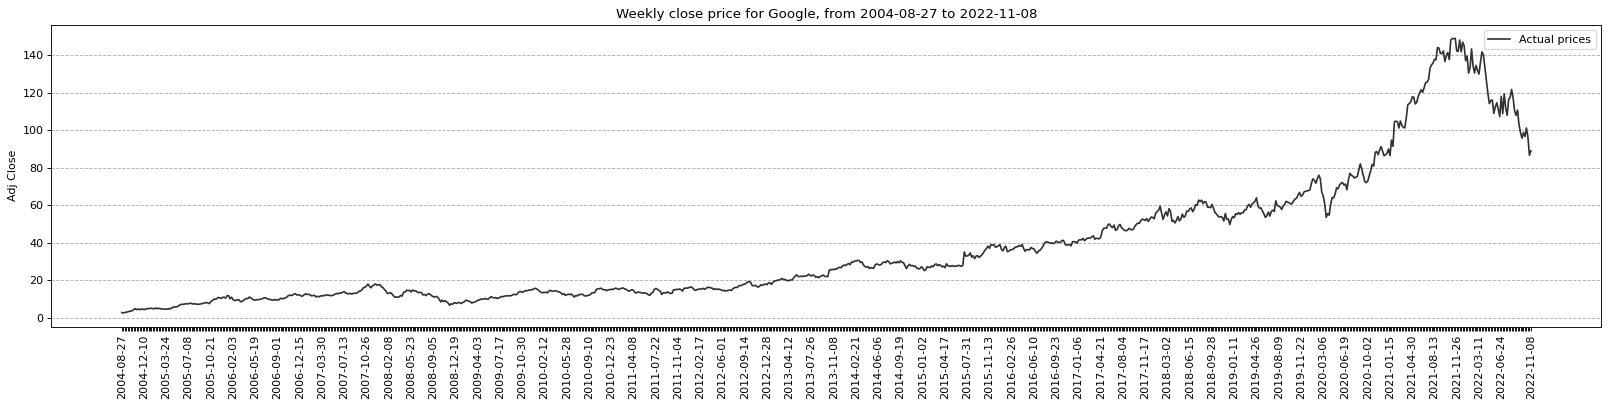

In [ ]:
plot_data(close_price)

#### Prepare data for training

In [ ]:
class Normalizer():
    def __init__(self):
        self.mu = None
        self.std = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0))
        self.std = np.std(x, axis=(0))
        normalized_x = (x - self.mu) / self.std
        return normalized_x

    def inverse_transform(self, x):
        return (x * self.std) + self.mu

# normalize
scaler = Normalizer()
normalized_close_price = np.array(scaler.fit_transform(close_price))

Number data points: 951 from 2004-08-27 to 2022-11-08


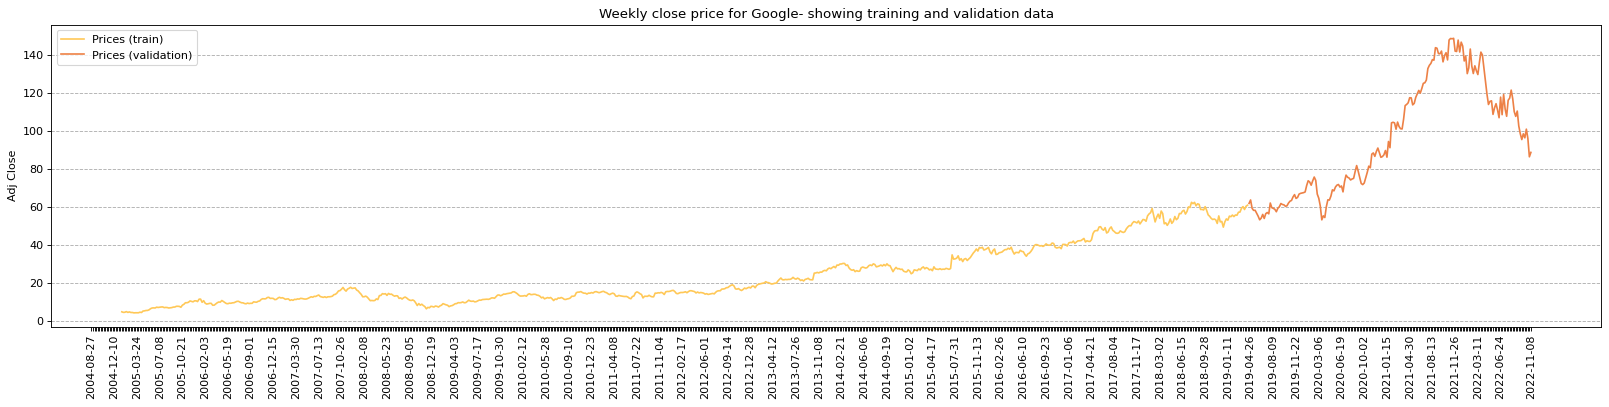

In [ ]:
def prepare_data_x(x, seq_length=20):
    # perform sliding window
    n_row = x.shape[0] - seq_length + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, seq_length), strides=(x.strides[0], x.strides[0]))
    return output[:-1], output[-1]

def prepare_data_y(x, seq_length=20):
    # use the next day as label
    output = x[seq_length:]
    return output

def prepare_data(normalized_data, seq_length=20):
    data_x, data_x_unseen = prepare_data_x(normalized_data, seq_length)
    data_y = prepare_data_y(normalized_data, seq_length)

    # split dataset
    split_index = int(data_y.shape[0] * split_ratio)
    data_x_train = data_x[:split_index]
    data_x_val = data_x[split_index:]
    data_y_train = data_y[:split_index]
    data_y_val = data_y[split_index:]

    data_split = {
        'x_train': data_x_train,
        'x_val': data_x_val,
        'train': data_y_train,
        'val': data_y_val,
        'split_index': split_index,
        'scaler': scaler
    }

    return data_split, data_x_unseen

data_split, data_x_unseen = prepare_data(normalized_close_price, seq_length)
plot_data(data_split=data_split, mode='split')

#### DataLoader

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2)
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

data_train = TimeSeriesDataset(data_split['x_train'], data_split['train'])
data_val = TimeSeriesDataset(data_split['x_val'], data_split['val'])

print("Train data shape", data_train.x.shape, data_train.y.shape)
print("Validation data shape", data_val.x.shape, data_val.y.shape)

Train data shape (744, 20, 1) (744,)
Validation data shape (187, 20, 1) (187,)


In [ ]:
# create `DataLoader`
batch_size = 64
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(data_val, batch_size=batch_size, shuffle=True)

### Initialize model

In [ ]:
input_size = 1
output_size = 1
hidden_dim = 32
n_layers = 2
device = 'cuda' # change to 'cpu' if no gpu to use

#### RNN

In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, output_size, hidden_dim, n_layers):
    super(RNN, self).__init__()

    # Parameters of RNN layers
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers

    # Init the layers
    ## RNN layer
    ### batch_first=True causes input/output tensors to be of shape
    ### (batch_size, seq_dim, feature_dim)
    self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
    ## FC layer
    self.dropout = nn.Dropout(0.2)
    self.fc = nn.Linear(n_layers * hidden_dim, output_size)


  def forward(self, x):
    batch_size = x.size(0)

    # Passing in the input and hidden state into the model and obtaining outputs
    _, hidden = self.rnn(x)

    # Reshaping the outputs for the FC layer
    out = hidden.permute(1, 0, 2).reshape(batch_size, -1)
    out = self.dropout(out)
    out = self.fc(out)

    return out[:, -1]

In [ ]:
rnn_model = RNN(input_size, output_size, hidden_dim, n_layers)
rnn_model.to(device)

RNN(
  (rnn): RNN(1, 32, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
summary(rnn_model, input_size=(1, 20, 1))

Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [1]                       --
├─RNN: 1-1                               [1, 20, 32]               3,232
├─Dropout: 1-2                           [1, 64]                   --
├─Linear: 1-3                            [1, 1]                    65
Total params: 3,297
Trainable params: 3,297
Non-trainable params: 0
Total mult-adds (M): 0.06
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 0.02

#### GRU

In [ ]:
class GRU(nn.Module):
  def __init__(self, input_size, output_size, hidden_dim, n_layers):
    super(GRU, self).__init__()

    # Parameters of RNN layers
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers

    # Init the layers
    ## GRU layer
    ### batch_first=True causes input/output tensors to be of shape
    ### (batch_size, seq_dim, feature_dim)
    self.gru = nn.GRU(input_size, hidden_dim, n_layers, batch_first=True)
    ## FC layer
    self.dropout = nn.Dropout(0.2)
    self.fc = nn.Linear(n_layers * hidden_dim, output_size)

  def forward(self, x):
    batch_size = x.size(0)

    _, hidden = self.gru(x)

    out = hidden.permute(1, 0, 2).reshape(batch_size, -1)
    out = self.dropout(out)
    out = self.fc(out)

    return out[:, -1]

In [ ]:
gru_model = GRU(input_size, output_size, hidden_dim, n_layers)
gru_model.to(device)

GRU(
  (gru): GRU(1, 32, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
summary(gru_model, input_size=(1, 20, 1))

Layer (type:depth-idx)                   Output Shape              Param #
GRU                                      [1]                       --
├─GRU: 1-1                               [1, 20, 32]               9,696
├─Dropout: 1-2                           [1, 64]                   --
├─Linear: 1-3                            [1, 1]                    65
Total params: 9,761
Trainable params: 9,761
Non-trainable params: 0
Total mult-adds (M): 0.19
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.04
Estimated Total Size (MB): 0.04

#### LSTM

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size, output_size, hidden_dim, n_layers):
    super(LSTM, self).__init__()

    # Parameters of RNN layers
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers

    # Init the layers
    ## LSTM layer
    ### batch_first=True causes input/output tensors to be of shape
    ### (batch_size, seq_dim, feature_dim)
    self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)
    ## FC layer
    self.dropout = nn.Dropout(0.2)
    self.fc = nn.Linear(n_layers * hidden_dim, output_size)

  def forward(self, x):
    batch_size = x.size(0)

    _, (h_n, _) = self.lstm(x)

    out = h_n.permute(1, 0, 2).reshape(batch_size, -1)
    out = self.dropout(out)
    out = self.fc(out)

    return out[:, -1]

In [ ]:
lstm_model = LSTM(input_size, output_size, hidden_dim, n_layers)
lstm_model.to(device)

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
summary(lstm_model, input_size=(1, 20, 1))

Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [1]                       --
├─LSTM: 1-1                              [1, 20, 32]               12,928
├─Dropout: 1-2                           [1, 64]                   --
├─Linear: 1-3                            [1, 1]                    65
Total params: 12,993
Trainable params: 12,993
Non-trainable params: 0
Total mult-adds (M): 0.26
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.05
Estimated Total Size (MB): 0.06

### Training stage

In [ ]:
def train_epoch(net, dataloader, lr=0.01, optimizer=None, loss_fn=nn.NLLLoss()):
  optimizer = optimizer or Adam(net.parameters(), lr=lr)
  net.train()
  total_loss, count = 0, 0
  for features, labels in dataloader:
    features, labels = features.cuda(), labels.cuda()
    optimizer.zero_grad()
    out = net(features)
    loss = loss_fn(out.contiguous(), labels.contiguous())
    loss.backward()
    optimizer.step()
    total_loss += loss
    count += len(labels)
  return total_loss.item()/count


def validate(net, dataloader, loss_fn=nn.NLLLoss()):
  net.eval()
  count, loss = 0, 0
  with torch.no_grad():
    for features, labels in dataloader:
      features, labels = features.cuda(), labels.cuda()
      out = net(features)
      loss += loss_fn(out.contiguous(), labels.contiguous())
      count += len(labels)
  return loss.item()/count

In [ ]:
def train(net, train_loader, val_loader,  optimizer=None, lr=0.01,
          scheduler=None, epochs=10, loss_fn=nn.NLLLoss(), process=True):
    optimizer = optimizer or Adam(net.parameters(), lr=lr)
    scheduler = scheduler or lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    res = { 'train_loss' : [], 'val_loss': []}
    for ep in range(epochs):
        tl = train_epoch(net, train_loader, optimizer=optimizer, lr=lr, loss_fn=loss_fn)
        vl = validate(net, val_loader, loss_fn=loss_fn)
        curr_lr = scheduler.get_last_lr()[0]
        scheduler.step()
        if process:
          print(f"Epoch {ep:2}, Train loss={tl:.6f}, Val loss={vl:.6f}, Lr={curr_lr}")
        res['train_loss'].append(tl)
        res['val_loss'].append(vl)
    return res

In [ ]:
# define optimizer, scheduler and loss function
epochs = 100
loss_fn = nn.MSELoss()
learning_rate = 0.01

#### Train RNN

In [ ]:
optimizer = Adam(rnn_model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

In [ ]:
hist_rnn = train(rnn_model, train_loader, val_loader,
                 optimizer, learning_rate, scheduler, epochs, loss_fn)
print()

Epoch  0, Train loss=0.001229, Val loss=0.008833, Lr=0.01
Epoch  1, Train loss=0.000160, Val loss=0.005552, Lr=0.01
Epoch  2, Train loss=0.000107, Val loss=0.005276, Lr=0.01
Epoch  3, Train loss=0.000084, Val loss=0.005037, Lr=0.01
Epoch  4, Train loss=0.000069, Val loss=0.004336, Lr=0.01
Epoch  5, Train loss=0.000059, Val loss=0.004306, Lr=0.01
Epoch  6, Train loss=0.000054, Val loss=0.004073, Lr=0.01
Epoch  7, Train loss=0.000052, Val loss=0.002776, Lr=0.01
Epoch  8, Train loss=0.000055, Val loss=0.003617, Lr=0.01
Epoch  9, Train loss=0.000048, Val loss=0.002975, Lr=0.01
Epoch 10, Train loss=0.000044, Val loss=0.003306, Lr=0.01
Epoch 11, Train loss=0.000047, Val loss=0.003595, Lr=0.01
Epoch 12, Train loss=0.000053, Val loss=0.003685, Lr=0.01
Epoch 13, Train loss=0.000067, Val loss=0.003307, Lr=0.01
Epoch 14, Train loss=0.000058, Val loss=0.003103, Lr=0.01
Epoch 15, Train loss=0.000048, Val loss=0.002879, Lr=0.01
Epoch 16, Train loss=0.000045, Val loss=0.002595, Lr=0.01
Epoch 17, Trai

#### Train GRU

In [ ]:
optimizer = Adam(gru_model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

In [ ]:
hist_rnn = train(gru_model, train_loader, val_loader,
                 optimizer, learning_rate, scheduler, epochs, loss_fn)
print()

Epoch  0, Train loss=0.001719, Val loss=0.002484, Lr=0.01
Epoch  1, Train loss=0.000181, Val loss=0.002136, Lr=0.01
Epoch  2, Train loss=0.000105, Val loss=0.005082, Lr=0.01
Epoch  3, Train loss=0.000079, Val loss=0.002832, Lr=0.01
Epoch  4, Train loss=0.000058, Val loss=0.002761, Lr=0.01
Epoch  5, Train loss=0.000056, Val loss=0.003402, Lr=0.01
Epoch  6, Train loss=0.000049, Val loss=0.002723, Lr=0.01
Epoch  7, Train loss=0.000049, Val loss=0.002340, Lr=0.01
Epoch  8, Train loss=0.000043, Val loss=0.002014, Lr=0.01
Epoch  9, Train loss=0.000048, Val loss=0.002342, Lr=0.01
Epoch 10, Train loss=0.000054, Val loss=0.002502, Lr=0.01
Epoch 11, Train loss=0.000042, Val loss=0.002336, Lr=0.01
Epoch 12, Train loss=0.000044, Val loss=0.002067, Lr=0.01
Epoch 13, Train loss=0.000047, Val loss=0.002200, Lr=0.01
Epoch 14, Train loss=0.000036, Val loss=0.001477, Lr=0.01
Epoch 15, Train loss=0.000038, Val loss=0.001556, Lr=0.01
Epoch 16, Train loss=0.000032, Val loss=0.000897, Lr=0.01
Epoch 17, Trai

#### Train LSTM

In [ ]:
optimizer = Adam(lstm_model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

In [ ]:
hist_rnn = train(lstm_model, train_loader, val_loader,
                 optimizer, learning_rate, scheduler, epochs, loss_fn)
print()

Epoch  0, Train loss=0.002713, Val loss=0.030362, Lr=0.01
Epoch  1, Train loss=0.000350, Val loss=0.018707, Lr=0.01
Epoch  2, Train loss=0.000145, Val loss=0.015964, Lr=0.01
Epoch  3, Train loss=0.000104, Val loss=0.018634, Lr=0.01
Epoch  4, Train loss=0.000078, Val loss=0.017061, Lr=0.01
Epoch  5, Train loss=0.000070, Val loss=0.016359, Lr=0.01
Epoch  6, Train loss=0.000060, Val loss=0.015228, Lr=0.01
Epoch  7, Train loss=0.000065, Val loss=0.013086, Lr=0.01
Epoch  8, Train loss=0.000056, Val loss=0.013325, Lr=0.01
Epoch  9, Train loss=0.000057, Val loss=0.013599, Lr=0.01
Epoch 10, Train loss=0.000053, Val loss=0.011906, Lr=0.01
Epoch 11, Train loss=0.000057, Val loss=0.011916, Lr=0.01
Epoch 12, Train loss=0.000061, Val loss=0.009781, Lr=0.01
Epoch 13, Train loss=0.000059, Val loss=0.009401, Lr=0.01
Epoch 14, Train loss=0.000045, Val loss=0.008995, Lr=0.01
Epoch 15, Train loss=0.000043, Val loss=0.007931, Lr=0.01
Epoch 16, Train loss=0.000042, Val loss=0.007066, Lr=0.01
Epoch 17, Trai

### Prediction

In [ ]:
def prediction(net, train_set, val_set):
  # reload data without shuffle to make prediction
  net.eval()

  # predict on the training data, to see how well the model managed to learn and memorize
  predicted_train = np.array([])
  for idx, (x, y) in enumerate(train_set):
    x = x.to(device)
    out = net(x)
    out = out.cpu().detach().numpy().flatten()
    predicted_train = np.concatenate((predicted_train, out))


  # predict on the validation data, to see model performance
  predicted_val = np.array([])
  for idx, (x, y) in enumerate(val_set):
    x = x.to(device)
    out = net(x)
    out = out.cpu().detach().numpy().flatten()
    predicted_val = np.concatenate((predicted_val, out))

  data_predict = {
  'train': predicted_train,
  'val': predicted_val,
  'split_index': data_split['split_index'],
  'scaler': scaler
  }

  return data_predict

In [ ]:
def plot_validation(data_y_val, predicted_val, split_index):
  # prepare data for plotting, zoom in validation
  data_y_val = scaler.inverse_transform(data_y_val)
  predicted_val = scaler.inverse_transform(predicted_val)
  data_date = data.index[split_index + seq_length:]
  num_data_points = len(data_date)
  xticks_interval = num_data_points * 90 // 5417

  # plots

  fig = plt.figure(figsize=(25, 5), dpi=80)
  fig.patch.set_facecolor((1.0, 1.0, 1.0))
  plt.plot(data_date, data_y_val, label="Actual prices", color=color['actual'])
  plt.plot(data_date, predicted_val, label="Predicted prices (validation)", color=color['pred_val'])
  plt.title("Zoom in to examine predicted price on validation data portion")
  xticks = [data_date[i] if ((i % xticks_interval == 0 and (num_data_points - i) > xticks_interval) or i == num_data_points - 1) \
            else None for i in range(num_data_points)] # make x ticks nice
  xs = np.arange(0, len(xticks))
  plt.xticks(xs, xticks, rotation='vertical')
  plt.grid(b=None, which='major', axis='y', linestyle='--')
  plt.legend()
  plt.show()

In [ ]:
# reload data without shuffle to make prediction
train_loader_no_shuffle = DataLoader(data_train, batch_size=batch_size, shuffle=False)
val_loader_no_shuffle = DataLoader(data_val, batch_size=batch_size, shuffle=False)

#### RNN prediction

Number data points: 951 from 2004-08-27 to 2022-11-08


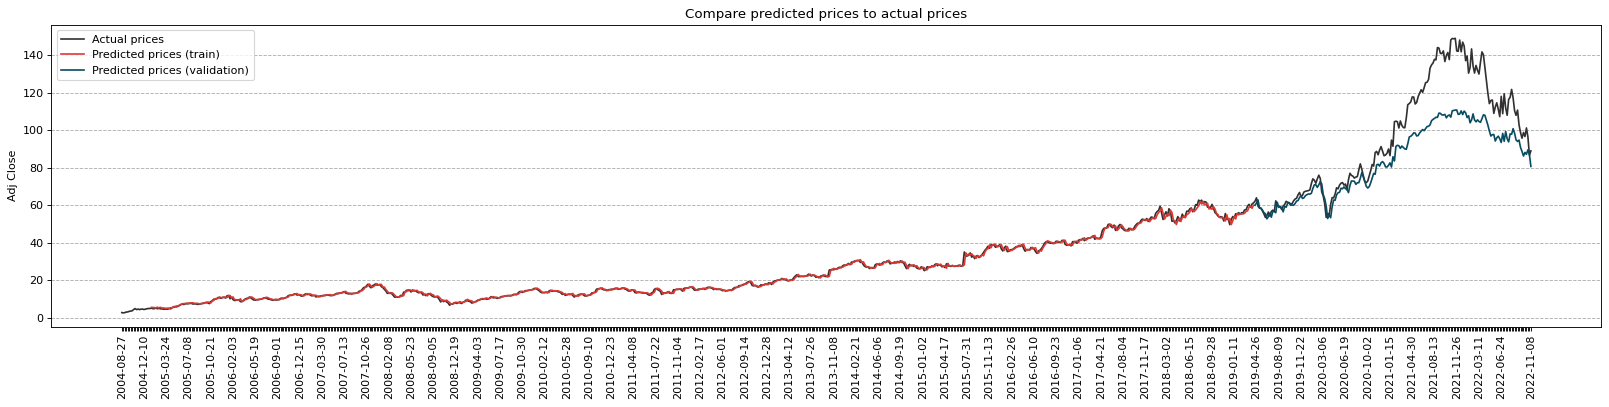

In [ ]:
data_predict = prediction(rnn_model, train_loader_no_shuffle, val_loader_no_shuffle)
plot_data(close_price, data_predict, 'compare')

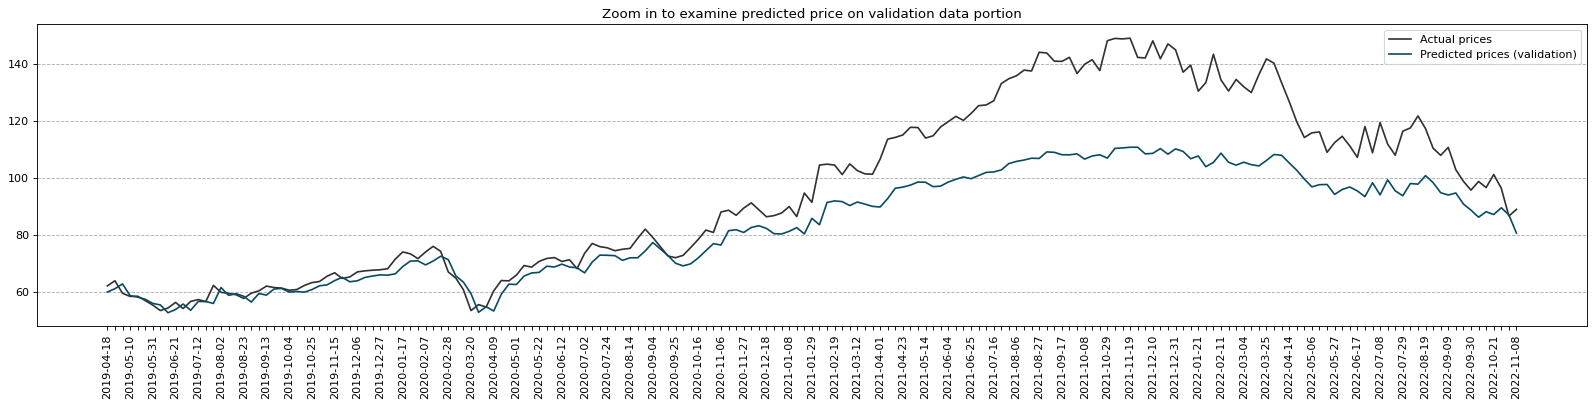

In [ ]:
plot_validation(data_split['val'], data_predict['val'], data_split['split_index'])

#### GRU prediction

Number data points: 951 from 2004-08-27 to 2022-11-08


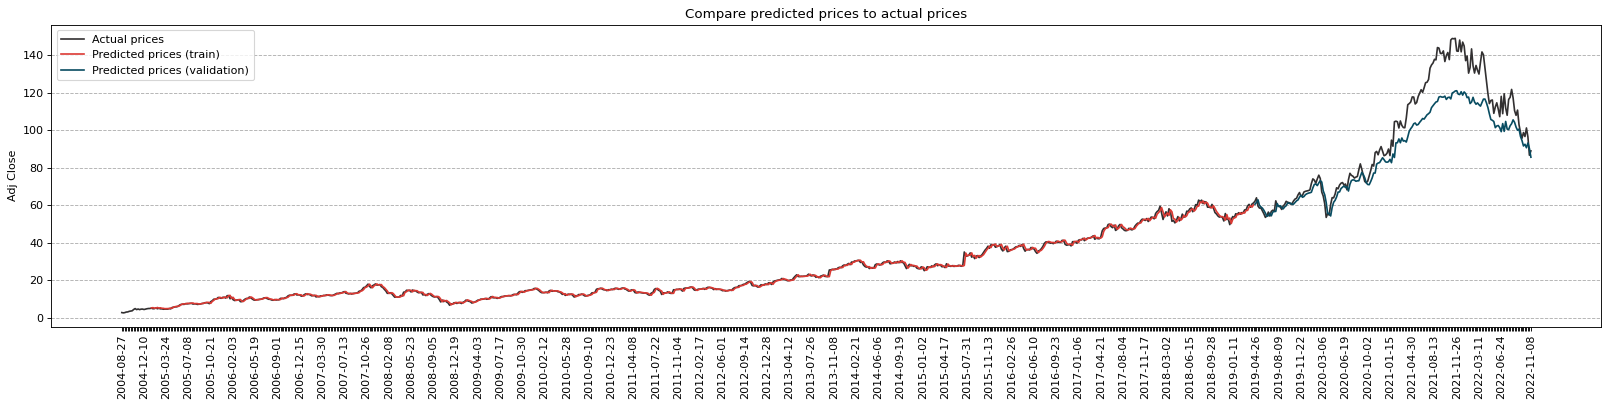

In [ ]:
data_predict = prediction(gru_model, train_loader_no_shuffle, val_loader_no_shuffle)
plot_data(close_price, data_predict, 'compare')

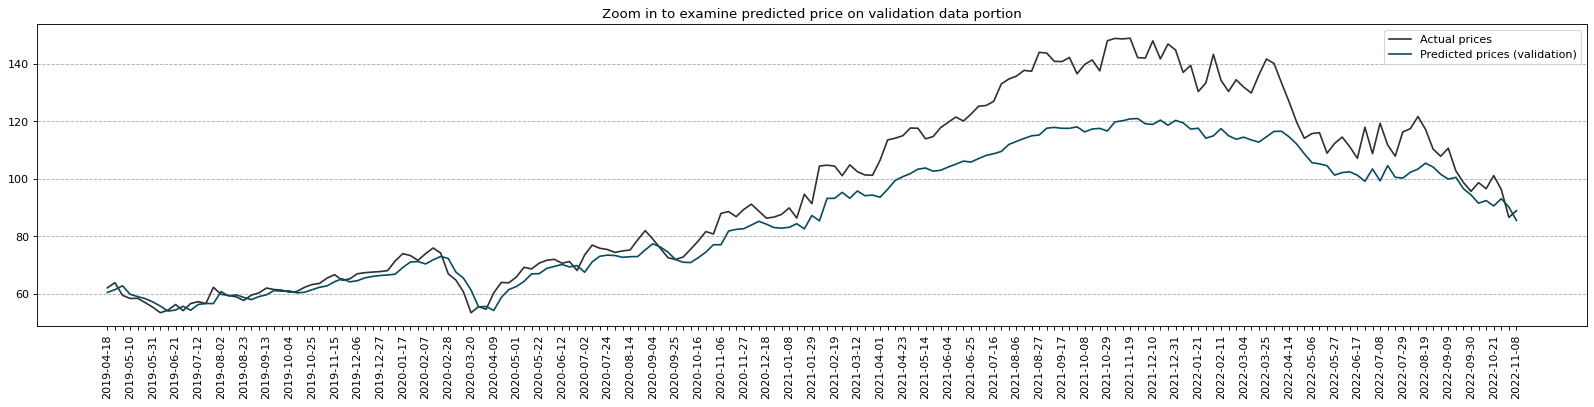

In [ ]:
plot_validation(data_split['val'], data_predict['val'], data_split['split_index'])

#### LSTM prediction

Number data points: 951 from 2004-08-27 to 2022-11-08


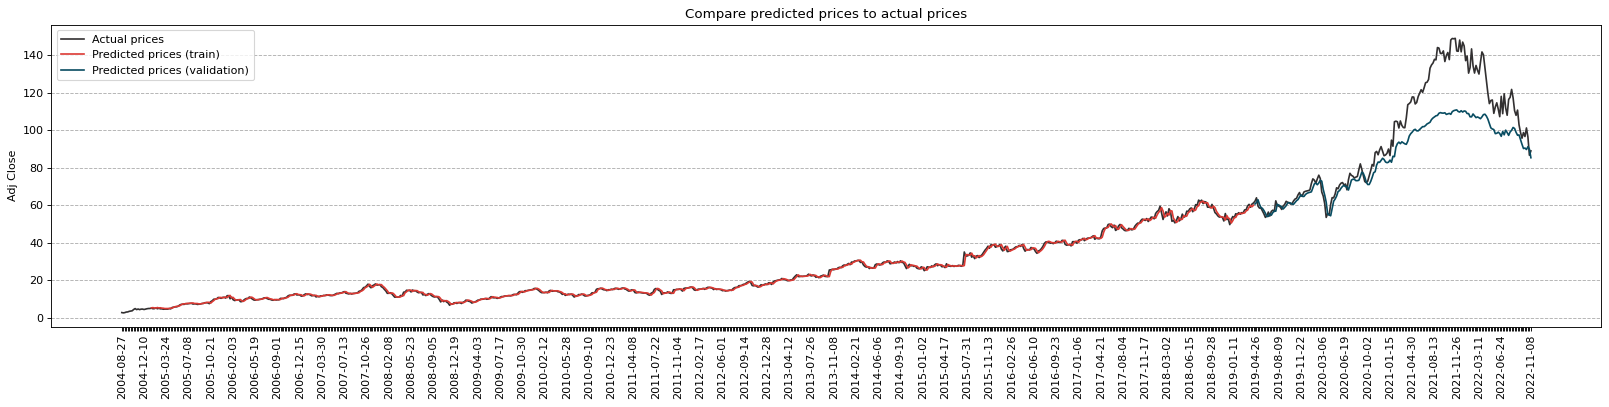

In [ ]:
data_predict = prediction(lstm_model, train_loader_no_shuffle, val_loader_no_shuffle)
plot_data(close_price, data_predict, 'compare')

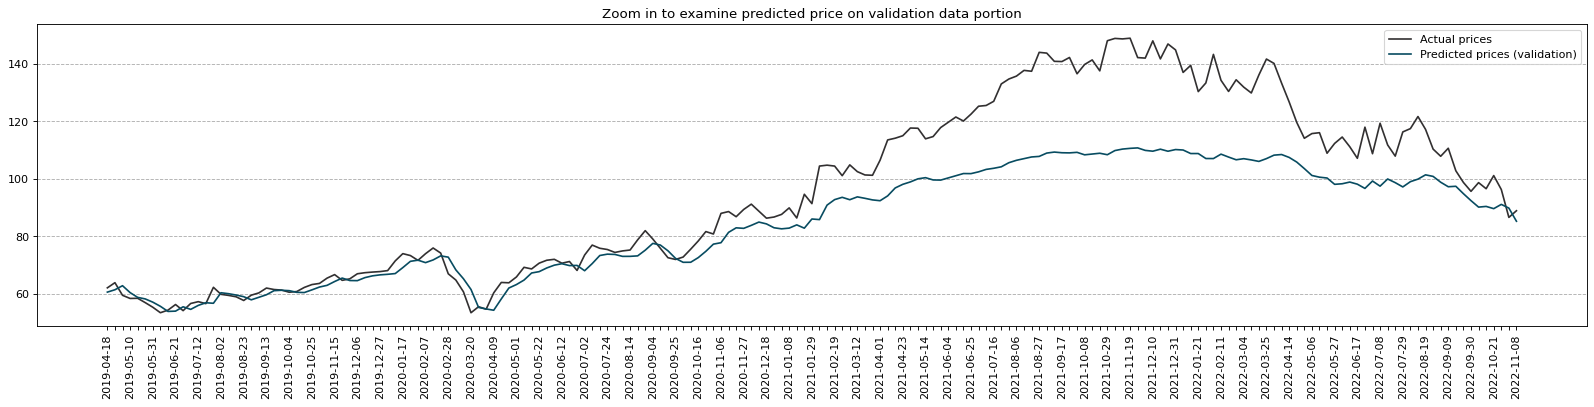

In [ ]:
plot_validation(data_split['val'], data_predict['val'], data_split['split_index'])

### Predict unseen data

In [ ]:
def plot_predict_unseen(prediction):
  # prepare data for plot
  plot_range = 10
  data_y_val = np.zeros(plot_range)
  data_y_val_pred = np.zeros(plot_range)
  data_y_test_pred = np.zeros(plot_range)

  data_y_val[:plot_range - 1] = scaler.inverse_transform(data_split['val'])[-plot_range + 1:]
  data_y_val_pred[:plot_range - 1] = scaler.inverse_transform(data_predict['val'])[-plot_range + 1:]

  data_y_test_pred[plot_range - 1] = prediction

  data_y_val = np.where(data_y_val == 0, None, data_y_val)
  data_y_val_pred = np.where(data_y_val_pred == 0, None, data_y_val_pred)
  data_y_test_pred = np.where(data_y_test_pred == 0, None, data_y_test_pred)

  # plot
  date_test = list(data.index)[-plot_range + 1:]
  date_test.append("next trading day")

  fig = plt.figure(figsize=(25, 5), dpi=80)
  fig.patch.set_facecolor((1.0, 1.0, 1.0))
  plt.plot(date_test, data_y_val, label="Actual prices", marker=".", markersize=10, color=color["actual"])
  plt.plot(date_test, data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=color["pred_val"])
  plt.plot(date_test, data_y_test_pred, label="Predicted price for next day", marker=".", markersize=20, color=color["pred_test"])
  plt.title("Predicted close price of the next trading day")
  plt.grid(b=None, which='major', axis='y', linestyle='--')
  plt.legend()
  plt.show()

#### RNN

Predicted close price of the next trading day: 81.96


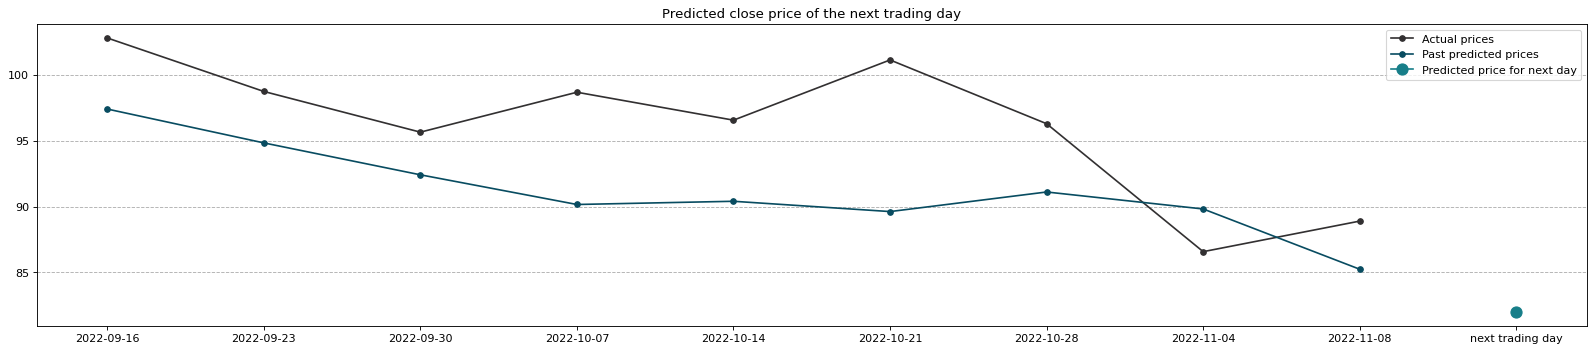

In [ ]:
# predict on the unseen data, tomorrow's price
rnn_model.eval()
x = torch.tensor(data_x_unseen).float().to(device).unsqueeze(0).unsqueeze(2)
prediction = rnn_model(x)
prediction = prediction.cpu().detach().numpy()
prediction = scaler.inverse_transform(prediction)[0]
print("Predicted close price of the next trading day:", round(prediction, 2))
plot_predict_unseen(prediction)

#### GRU

Predicted close price of the next trading day: 85.32


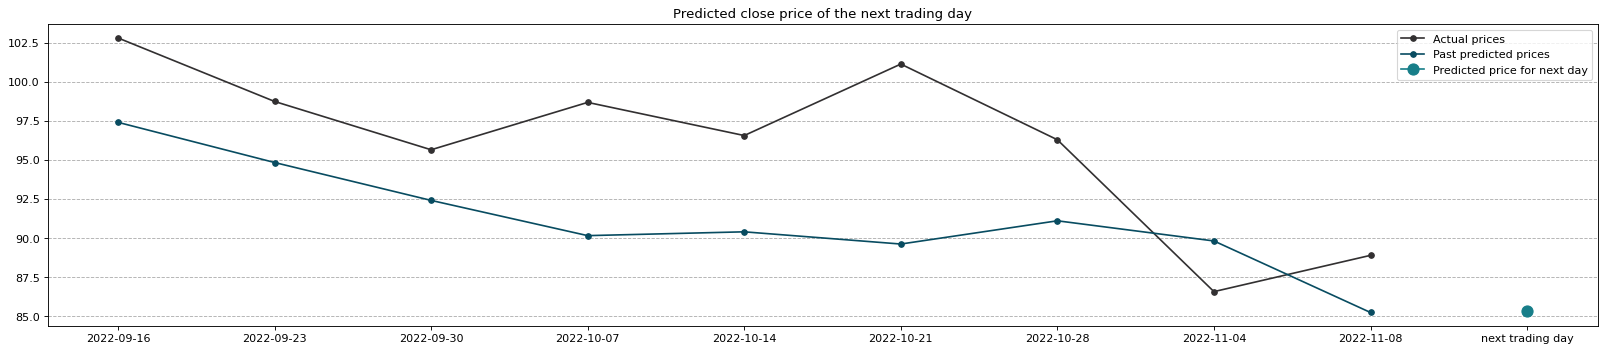

In [ ]:
# predict on the unseen data, tomorrow's price
gru_model.eval()
x = torch.tensor(data_x_unseen).float().to(device).unsqueeze(0).unsqueeze(2)
prediction = gru_model(x)
prediction = prediction.cpu().detach().numpy()
prediction = scaler.inverse_transform(prediction)[0]
print("Predicted close price of the next trading day:", round(prediction, 2))
plot_predict_unseen(prediction)

#### LSTM

Predicted close price of the next trading day: 84.47


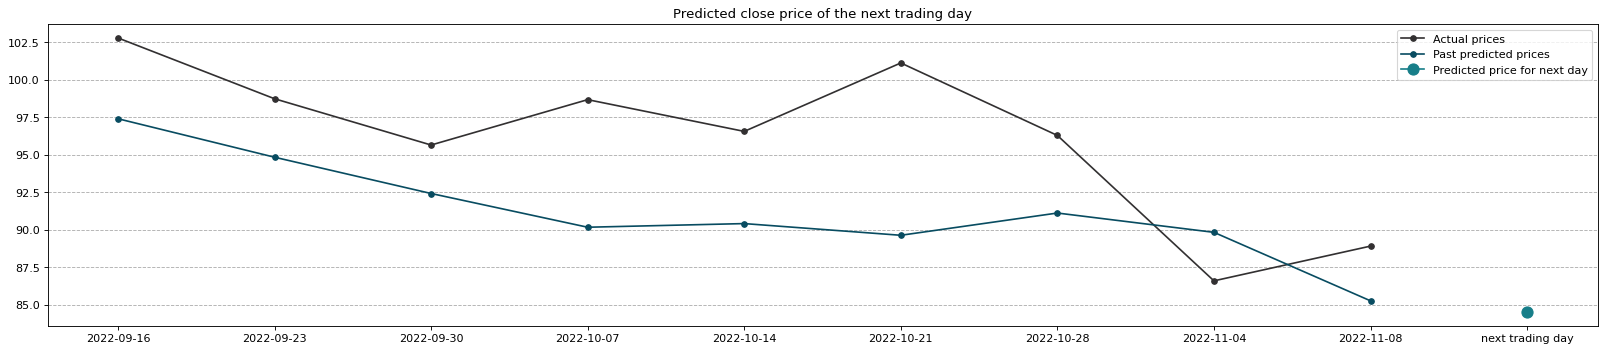

In [ ]:
# predict on the unseen data, tomorrow's price
lstm_model.eval()
x = torch.tensor(data_x_unseen).float().to(device).unsqueeze(0).unsqueeze(2)
prediction = lstm_model(x)
prediction = prediction.cpu().detach().numpy()
prediction = scaler.inverse_transform(prediction)[0]
print("Predicted close price of the next trading day:", round(prediction, 2))
plot_predict_unseen(prediction)

### References
- *Data preparation and visualisation*: https://github.com/jinglescode/time-series-forecasting-pytorch